* Project: Loan Outcome Classification
* Author: Dmitri Kochubei
* Purpose: Correclty predict outcome of a given loan ('Paid-off'/'Charged-off')
* Created: 03.11.2020

In [52]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from imblearn.over_sampling import SMOTE

import scikitplot as skplt # library to plot ML metrics
# https://scikit-plot.readthedocs.io/en/stable/index.html#
import matplotlib.pyplot as plt
import pickle

from imblearn.over_sampling import SMOTE 

%matplotlib
%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 100) #  display all the columns
pd.set_option('display.max_rows', 100) # display all the rows
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

Using matplotlib backend: MacOSX


# Loading training data

In [29]:
df = pd.read_csv('Data/2_bins_train.csv')
df = df.sample(20000,random_state=666)
df.drop('Unnamed: 0',axis=1,inplace=True)
X_train = df.drop('training labels',axis='columns')
y_train = df['training labels'].values.ravel()

# SMOTE for imbalanced data

In [30]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Loading testing data

In [34]:
df = pd.read_csv('Data/2_bins_test.csv')
df = df.sample(2000,random_state=66)
df.drop('Unnamed: 0',axis=1,inplace=True)
X_test = df.drop('testing labels',axis='columns')
y_test = df['testing labels'].values.ravel()

# Cycling through the selected models, extracting metrics

In [47]:
# create a list of classifiers 
classifiers = [LogisticRegression(random_state=1234,solver='sag',max_iter=10000), 
               RandomForestClassifier(random_state=1234),GaussianNB(),
               KNeighborsClassifier(n_neighbors=100)]


result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc',
                                    'precision','recall',
                                    'precision score'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    
    yproba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    precision,recall,_ = precision_recall_curve(y_test,yproba)
    average_precision = average_precision_score(y_test,yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'precision':precision,
                                        'recall':recall,
                                        'precision score':average_precision}, 
                                       ignore_index=True)
    
    print('{} - DONE'.format(cls))

result_table.set_index('classifiers', inplace=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False) - DONE
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False) - DONE
GaussianNB(priors=None, var_smoothing=1e-09) - DONE
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='

# Recall vs Precision curve

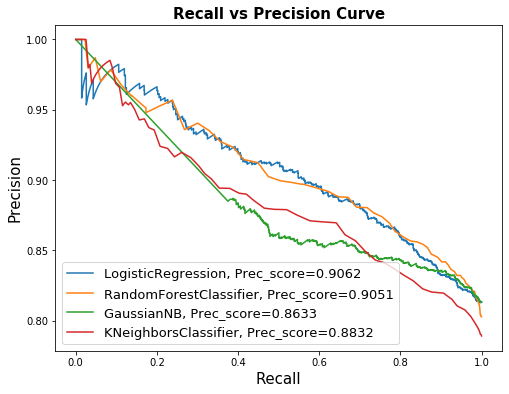

In [49]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['recall'],result_table.loc[i]['precision'],
            label="{}, Prec_score={:.4f}".format(i, result_table.loc[i]['precision score']))
    
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)

plt.title('Recall vs Precision Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower left')
plt.savefig('images/recall_precision.png')
plt.show()

# Plotting ROC

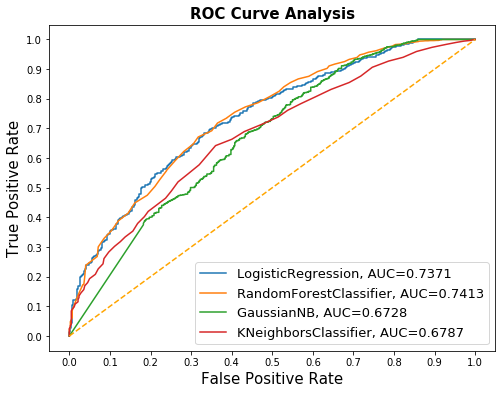

In [37]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.4f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.savefig('images/ROC.png')
plt.show()

# Learning Curves

In [ ]:
for i in range(len(result_table)):
        skplt.estimators.plot_learning_curve(classifiers[i], X_train, y_train,
                                            title=result_table.index[i])
        plt.savefig('images/{}learning_curve.png'.format(result_table.index[i]))
        #plt.savefig(result_table.index[i])
fig.tight_layout()

skplt.estimators.plot_learning_curve(classifiers[0], X_train, y_train)

# Logistic Regression GridSearchCV

In [207]:
logreg = LogisticRegression(solver='sag',max_iter=10000)
param = {'C':[25,20]}
clf = GridSearchCV(logreg,param,scoring='precision',refit=True,cv=10)
clf.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with hyperparameter: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.8283, with hyperparameter: {'C': 25}


# Confusion matrix for best performing model.

In [ ]:
best_model = LogisticRegression(solver='sag',max_iter=10000,C=25)
best_model.fit(X_train, y_train)

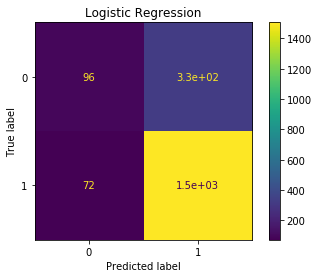

In [50]:
plot_confusion_matrix(best_model,X_test,y_test)
plt.title('Logistic Regression')
plt.show()

In [44]:
predicted = best_model.predict(X_test)

# get the accuracy
print(accuracy_score(y_test, predicted))


0.801


In [ ]:
print(classification_report(y_test, predicted))

# Saving the model

In [273]:
filename = 'Models/logit_model.sav'
pickle.dump(logisticRegr, open(filename, 'wb')) 

#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))